# Getting Started

## Overview
This semester, all homeworks will be conducted through Google Colab notebooks. All code for the homework assignment will be written and run in this notebook. Running in Colab will automatically provide a GPU, but you may also run this notebook locally by following [these instructions](https://research.google.com/colaboratory/local-runtimes.html) if you wish to use your own GPU.

You will save images in the notebooks to use and fill out a given LaTeX template which will be submitted to Gradescope, along with your notebook code.

## Using Colab
On the left-hand side, you can click the different icons to see a Table of Contents of the assignment, as well as local files accessible through the notebook.

Make sure to go to **Runtime -> Change runtime type** and select **GPU** as the hardware accelerator. This allows you to use a GPU. Run the cells below to get started on the assignment. Note that a session is open for a maximum of 12 hours, and using too much GPU compute may result in restricted access for a short period of time. Please start the homework early so you have ample time to work.

**If you loaded this notebook from clicking "Open in Colab" from github, you will need to save it to your own Google Drive to keep your work.**

## General Tips
In each homework problem, you will implement an autoregressive model and run it on two datasets (dataset 1 and dataset 2). The expected outputs for dataset 1 are already provided to help as a sanity check.

Feel free to print whatever output (e.g. debugging code, training code, etc) you want, as the graded submission will be the submitted pdf with images.

After you complete the assignment, download all of the image outputted in the results/ folder and upload them to the figure folder in the given latex template.

Run the cells below to download and load up the starter code. It may take longer to run since we are using larger datasets.

In [ ]:
!if [ -d deepul ]; then rm -Rf deepul; fi
!git clone https://github.com/rll/deepul.git 
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1lWjGICwgzgcBDejo9S5g69hLAf0O3lGF" -O hw3_data.zip && rm -rf /tmp/cookies.txt
!unzip -qq hw3_data.zip -d deepul/homeworks/hw3/data
!rm hw3_data.zip
!pip install ./deepul

In [2]:
from deepul.hw3_helper import *

# Question 1: VAEs on 2D Data [20pts]
In this question, you will train a simple VAE on 2D data, and look at situations in which latents are being used or not being used (i.e. when posterior collapse occurs)

## Part (a) Data from a Full Covariance Gaussian [10 pts]
In this part, we train a VAE on data generated from a Gaussian with a full covariance matrix. Execute the cell below to visualize the datasets.

Dataset 1


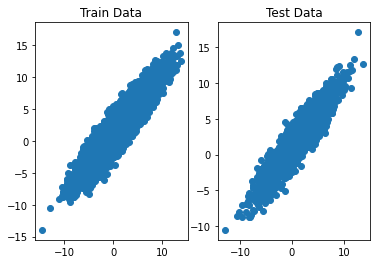

Dataset 2


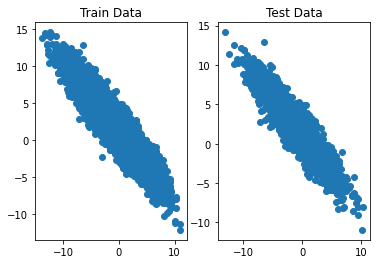

In [3]:
visualize_q1_data('a', 1)
visualize_q1_data('a', 2)

Consruct and train a VAE with the following characteristics
*   2D latent variables $z$ with a standard normal prior, $p(z) = N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), \Sigma_\phi(z))$, where $\mu_\phi(z)$ is the mean vector, and $\Sigma_\phi(z)$ is a diagonal covariance matrix

**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss $E_xE_{z\sim q(z|x)}[-\log{p(x|z)}]$, and KL term $E_x[D_{KL}(q(z|x)||p(z))]$ of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. Samples of your trained VAE with ($z\sim p(z), x\sim N(x;\mu_\phi(z),\Sigma_\phi(z))$) and without ($z\sim p(z), x = \mu_\phi(z)$) decoder noise




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [148]:
from collections import OrderedDict
from tqdm.auto import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.utils.data as data
import torch.optim as optim
from collections import defaultdict

In [149]:
class Q1Trainer:
    """ Q1 Trainer """
    def __init__(self, model, device, train_loader, test_loader, epochs, lr):
        self.model = model
        self.device = device
        self.train_loader = train_loader
        self.test_loader = test_loader
        self.epochs = epochs
        self.lr = lr
    
    def _optim_step(self, loss):
        self.optim.zero_grad()
        loss.backward()
        self.optim.step()
    
    def _train(self):
        self.model.train()

        for batch in self.train_loader:
            batch = batch.to(self.device)
            loss, recon_loss, kl_loss = self.model.getloss(batch)
            self._optim_step(loss)
            self.train_losses['loss'].append(loss.item())
            self.train_losses['recon_loss'].append(recon_loss.item())
            self.train_losses['kl_loss'].append(kl_loss.item())
    
    @torch.no_grad()
    def _test(self):
        self.model.eval()
        total_loss, total_recon_loss, total_kl_loss  = 0., 0., 0.

        for batch in self.test_loader:
            batch = batch.to(self.device)
            loss, recon_loss, kl_loss = self.model.getloss(batch)
            
            total_loss += loss.item() * len(batch)
            total_recon_loss += recon_loss.item() * len(batch)
            total_kl_loss += kl_loss.item() * len(batch)
            
        total_loss /= len(self.test_loader.dataset)
        total_recon_loss /= len(self.test_loader.dataset)
        total_kl_loss /= len(self.test_loader.dataset)
        self.test_losses['loss'].append(total_loss)
        self.test_losses['recon_loss'].append(total_recon_loss)
        self.test_losses['kl_loss'].append(total_kl_loss)
    
    def _prepare_tools(self):
        self.optim = optim.Adam(self.model.parameters(), lr=self.lr)
        self.train_losses = defaultdict(list)
        self.test_losses = defaultdict(list)
        self._test()
    
    def run(self):
        self._prepare_tools()

        for epoch in tqdm(range(self.epochs), leave=False):
            self._train()
            self._test()
        
        # cat
        cat_train_losses = np.stack((self.train_losses['loss'], self.train_losses['recon_loss'], self.train_losses['kl_loss']), axis=1)
        cat_test_losses = np.stack((self.test_losses['loss'], self.test_losses['recon_loss'], self.test_losses['kl_loss']), axis=1) 

        return cat_train_losses, cat_test_losses

In [57]:
class Q1VAE(nn.Module):
    """ Q1 VAE """
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 4),
        )
        self.decoder = nn.Sequential(
            nn.Linear(2, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 4),
        )

    def getloss(self, x):

        enc_out = self.encoder(x)
        enc_mu, enc_logstd = enc_out.chunk(2, dim=1)
        z = torch.randn_like(enc_mu) * enc_logstd.exp() + enc_mu

        dec_out = self.decoder(z)
        dec_mu, dec_logstd = dec_out.chunk(2, dim=1)
        
        rec_CONST = 0.5 * np.log(2 * np.pi)
        recon_loss = (rec_CONST + dec_logstd + torch.pow(x - dec_mu, 2) * torch.exp(-2 * dec_logstd) / 2).sum(1).mean()

        kl_CONST = - enc_logstd - 0.5
        kl_loss = (kl_CONST + (torch.exp(2 * enc_logstd) + enc_mu ** 2) / 2).sum(1).mean()

        return recon_loss + kl_loss, recon_loss, kl_loss

    def sample(self, n, noise=True):
        with torch.no_grad():
            z = torch.randn(n, 2).cuda()
            mu, log_std = self.decoder(z).chunk(2, dim=1)
            if noise:
                z = torch.randn_like(mu) * log_std.exp() + mu
            else:
                z = mu
        return z.cpu().numpy()

In [68]:
def q1(train_data, test_data, part, dset_id):
    """
    train_data: An (n_train, 2) numpy array of floats
    test_data: An (n_test, 2) numpy array of floats

    (You probably won't need to use the two inputs below, but they are there
     if you want to use them)
    part: An identifying string ('a' or 'b') of which part is being run. Most likely
          used to set different hyperparameters for different datasets
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a numpy array of size (1000, 2) of 1000 samples WITH decoder noise, i.e. sample z ~ p(z), x ~ p(x|z)
    - a numpy array of size (1000, 2) of 1000 samples WITHOUT decoder noise, i.e. sample z ~ p(z), x = mu(z)
    """

    """ YOUR CODE HERE """
    # params
    BATCH_SIZE = 128
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    EPOCHS = 10
    LR = 1e-3

    # data
    train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    # model
    model = Q1VAE().to(DEVICE)

    # train
    trainer = Q1Trainer(model, DEVICE, train_loader, test_loader, EPOCHS, LR)
    train_losses, test_losses = trainer.run()

    # sample
    noise_z = torch.randn(1000, 2).to(DEVICE)
    z = torch.randn(1000, 2).to(DEVICE)
    with torch.no_grad():
        dec_out = model.decoder(noise_z)
        mu, logstd = dec_out.chunk(2, dim=1)
        noise_samples = (torch.randn_like(mu) * logstd.exp() + mu).detach().cpu().numpy()

        dec_out = model.decoder(z)
        mu, logstd = dec_out.chunk(2, dim=1)
        samples = mu.detach().cpu().numpy()

    return train_losses, test_losses, noise_samples, samples

### Results
Once you've finished `q1_a`, execute the cells below to visualize and save your results.

Final -ELBO: 4.5512, Recon Loss: 3.0437, KL Loss: 1.5075


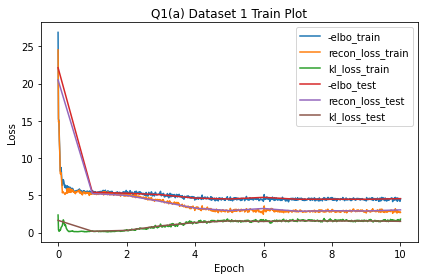

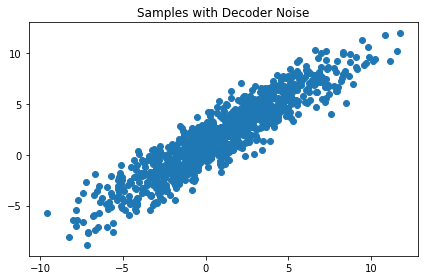

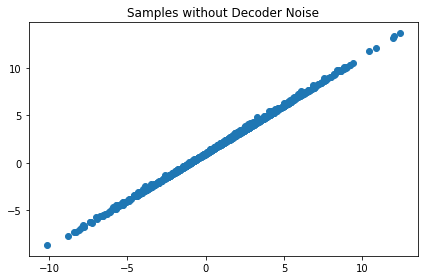

In [69]:
q1_save_results('a', 1, q1)

Final -ELBO: 4.6432, Recon Loss: 2.9457, KL Loss: 1.6974


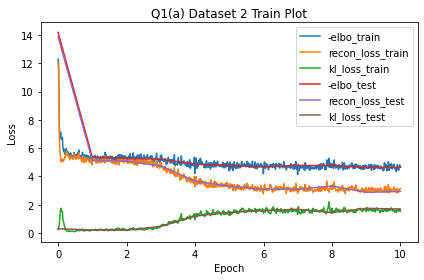

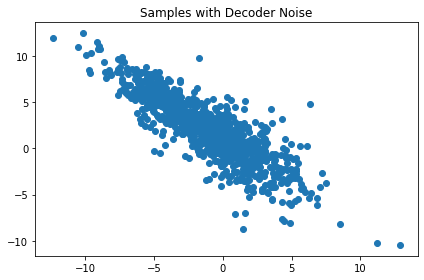

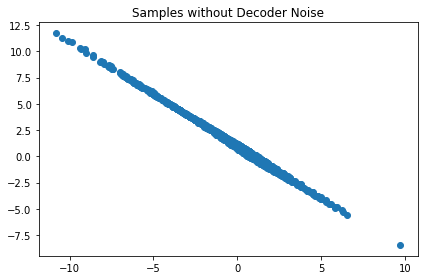

In [70]:
q1_save_results('a', 2, q1)

## Part (b) Data from a Diagonal Gaussian [10pts]
In this part, we use your code from the previous part to train a VAE on data generated from a diagonal gaussian. Execute the cell below to visualize the datasets (note that they may look the same, but notice the axes)

Dataset 1


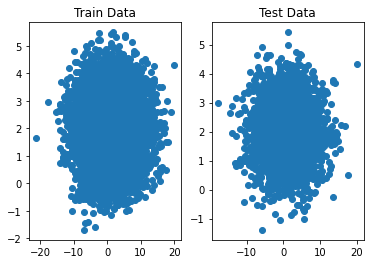

Dataset 2


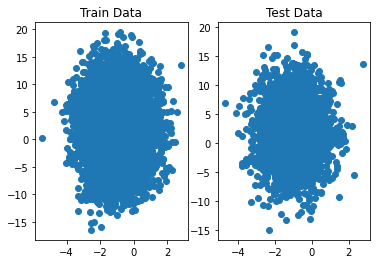

In [61]:
visualize_q1_data('b', 1)
visualize_q1_data('b', 2)

### Results
Execute the cells below to visualize and save your results.

Final -ELBO: 4.4229, Recon Loss: 4.4130, KL Loss: 0.0099


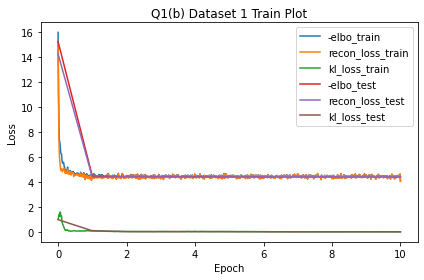

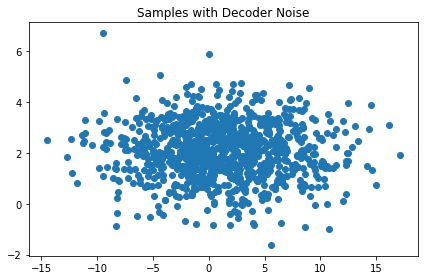

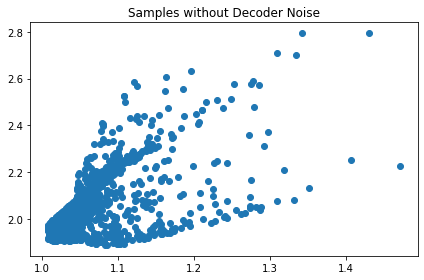

In [71]:
q1_save_results('b', 1, q1)

Final -ELBO: 4.4217, Recon Loss: 4.4165, KL Loss: 0.0052


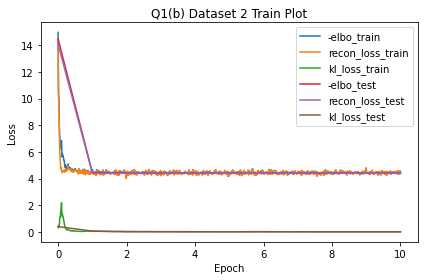

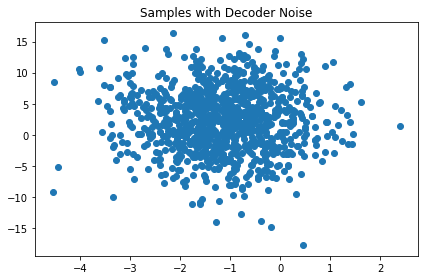

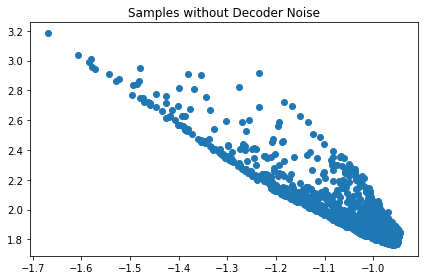

In [72]:
q1_save_results('b', 2, q1)

### Reflection
Compare the sampled xs with and without decoder noise in parts (a) and (b). For which datasets are the latents being used? Why is this happening (i.e. why are the latents being ignored in some cases)? **Write your answer (1-2 sentences) in the given latex template**

# Question 2: VAEs on Images [40pts]
In this question, you will train different VAE models on image datasets. Execute the cell below to visualize the two datasets (colored shapes, and [SVHN](http://ufldl.stanford.edu/housenumbers/)).

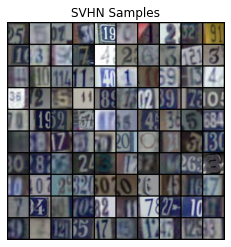

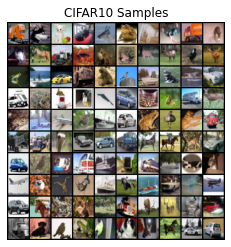

In [73]:
visualize_svhn()
visualize_cifar10()

## Part (a) VAE [20pts]
In this part, implement a standard VAE with the following characteristics:

*   16-dim latent variables $z$ with standard normal prior $p(z) = N(0,I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can play around with different architectures and try for better results, but the following encoder / decoder architecture below suffices (Note that image input is always $32\times 32$.
```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)

Encoder
    conv2d(3, 32, 3, 1, 1)
    relu()
    conv2d(32, 64, 3, 2, 1) # 16 x 16
    relu() 
    conv2d(64, 128, 3, 2, 1) # 8 x 8
    relu()
    conv2d(128, 256, 3, 2, 1) # 4 x 4
    relu()
    flatten()
    linear(4 * 4 * 256, 2 * latent_dim)

Decoder
    linear(latent_dim, 4 * 4 * 128)
    relu()
    reshape(4, 4, 128)
    transpose_conv2d(128, 128, 4, 2, 1) # 8 x 8
    relu()
    transpose_conv2d(128, 64, 4, 2, 1) # 16 x 16
    relu()
    transpose_conv2d(64, 32, 4, 2, 1) # 32 x 32
    relu()
    conv2d(32, 3, 3, 1, 1)
```

You may find the following training tips helpful
*   When computing reconstruction loss and KL loss, average over the batch dimension and **sum** over the feature dimension
*   When computing reconstruction loss, it suffices to just compute MSE between the reconstructed $x$ and true $x$ (you can compute the extra constants if you want)
*   Use batch size 128, learning rate $10^{-3}$, and an Adam optimizer




**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. Interpolations of length 10 between 10 pairs of test images from your VAE (100 images total)



### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [74]:
class Q2Trainer(Q1Trainer):
    """ Q2 Trainer """
    pass

In [129]:
class Q2VAE(nn.Module):
    """ Q2 VAE """
    def __init__(self):
        super().__init__()

        class Reshape(nn.Module):
            def __init__(self, shape=(-1,)):
                super().__init__()
                self.shape = shape

            def forward(self, x):
                bs = len(x)
                return x.view(bs, *self.shape)

        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            Reshape(),
            nn.Linear(4096, 2 * 16),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 2048),
            Reshape(shape=(128, 4, 4)),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1),
        )

    def getloss(self, x):
        x = 2 * x - 1

        enc_out = self.encoder(x)
        mu, logstd = enc_out.chunk(2, dim=1)
        z = torch.randn_like(mu) * logstd.exp() + mu

        rx = self.decoder(z)

        recon_loss = F.mse_loss(x, rx, reduction='none').view(len(x), -1).sum(1).mean()

        CONST = - logstd - 0.5
        kl_loss = (CONST + (torch.exp(2 * logstd) + mu ** 2) / 2).sum(1).mean()

        return recon_loss + kl_loss, recon_loss, kl_loss


In [133]:
def q2_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """
    # params
    BATCH_SIZE = 128
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    EPOCHS = 20
    LR = 1e-3

    # data
    train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255.).astype('float32')
    test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255.).astype('float32')

    train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    # model
    model = Q2VAE().to(DEVICE)

    # train
    trainer = Q2Trainer(model, DEVICE, train_loader, test_loader, EPOCHS, LR)
    train_losses, test_losses = trainer.run()

    # sample
    with torch.no_grad():
        z = torch.randn(100, 16).cuda()
        samples = model.decoder(z)
        samples = torch.clamp(samples, -1, 1)
    samples = (samples.detach().cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5) * 255

    # recon
    batch = next(iter(test_loader))
    x = batch[:50].to(DEVICE)

    with torch.no_grad():
        x = 2 * x - 1
        enc_out = model.encoder(x)
        z, _ = enc_out.chunk(2, dim=1)

        rx = model.decoder(z)
        rx = torch.clamp(rx, -1, 1)

    recon = torch.stack((x, rx), dim=1).view(-1, 3, 32, 32) * 0.5 + 0.5
    recon = recon.permute(0, 2, 3, 1).detach().cpu().numpy() * 255

    # interp
    batch = next(iter(test_loader))
    x = batch[:20].to(DEVICE)

    with torch.no_grad():
        x = 2 * x - 1
        enc_out = model.encoder(x)
        z, _ = enc_out.chunk(2, dim=1)
        z1, z2 = z.chunk(2, dim=0)

        interp = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
        interp = torch.stack(interp, dim=1).view(-1, 3, 32, 32)
        interp = torch.clamp(interp, -1, 1) * 0.5 + 0.5

    interp = interp.permute(0, 2, 3, 1).detach().cpu().numpy() * 255

    return train_losses, test_losses, samples, recon, interp

### Results
Once you've finished `q2_a`, execute the cells below to visualize and save your results.

Final -ELBO: 104.2839, Recon Loss: 79.5994, KL Loss: 24.6845


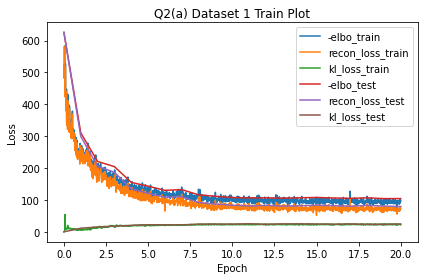

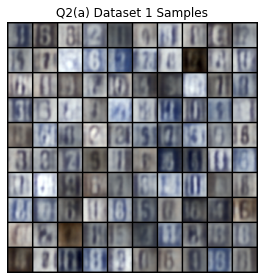

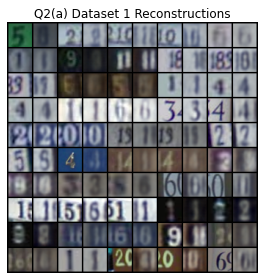

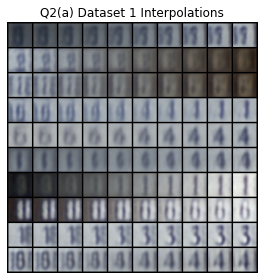

In [134]:
q2_save_results('a', 1, q2_a)

Final -ELBO: 241.3935, Recon Loss: 211.4472, KL Loss: 29.9462


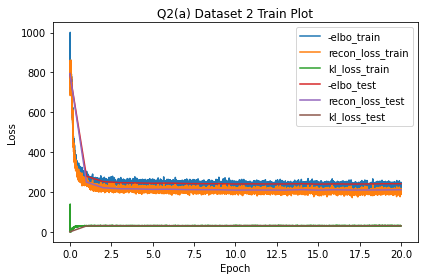

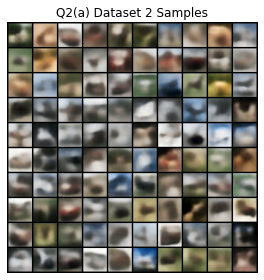

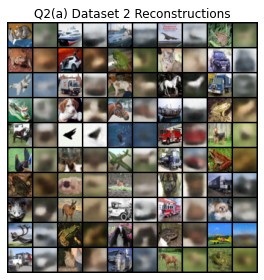

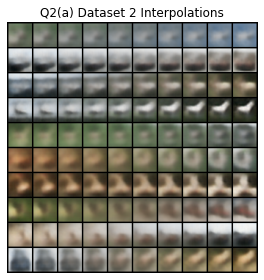

In [135]:
q2_save_results('a', 2, q2_a)

## Part (b) VAE with AF Prior [20pts]
In this part, implement a VAE with an Autoregressive Flow prior ([VLAE](https://arxiv.org/abs/1611.02731)) with the following characteristics:

*   16-dim latent variables $z$ with a MADE prior, with $\epsilon \sim N(0, I)$
*   An approximate posterior $q_\theta(z|x) = N(z; \mu_\theta(x), \Sigma_\theta(x))$, where $\mu_\theta(x)$ is the mean vector, and $\Sigma_\theta(x)$ is a diagonal covariance matrix
*   A decoder $p(x|z) = N(x; \mu_\phi(z), I)$, where $\mu_\phi(z)$ is the mean vector. (We are not learning the covariance of the decoder)

You can use the same encoder / decoder architectures and training hyperparameters as part (a). For your MADE prior, it would suffice to use two hidden layers of size $512$. More explicitly, your MADE AF (mapping from $z\rightarrow \epsilon$) should output location $\mu_\psi(z)$ and scale parameters $\sigma_\psi(z)$ and do the following transformation on $z$:
$$\epsilon = z \odot \sigma_\psi(z) + \mu_\psi(z)$$

where the $i$th element of $\sigma_\psi(z)$ is computed from $z_{<i}$ (same for $\mu_\psi(z)$) and optimize the objective

$$-E_{z\sim q(z|x)}[\log{p(x|z)}] + E_{z\sim q(z|x)}[\log{q(z|x)} - \log{p(z)}]$$
where $$\log{p(z)} = \log{p(\epsilon)} + \log{\det\left|\frac{d\epsilon}{dz}\right|}$$





**You will provide the following deliverables**


1.   Over the course of training, record the average full negative ELBO, reconstruction loss, and KL term of the training data (per minibatch) and test data (for your entire test set). Code is provided that automatically plots the training curves. 
2.   Report the final test set performance of your final model
3. 100 samples from your trained VAE
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)
5. Interpolations of length 10 between 10 pairs of test images from your VAE (100 images total)




### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [80]:
class Q3Trainer(Q1Trainer):
    """ Q3 Trainer """
    pass

In [207]:
class Reshape(nn.Module):
    def __init__(self, shape=(-1,)):
        super().__init__()
        self.shape = shape

    def forward(self, x):
        bs = len(x)
        return x.view(bs, *self.shape)


class MLinear(nn.Linear):

    def __init__(self, in_features, out_features):
        super().__init__(in_features, out_features)
        self.register_buffer('m', torch.ones(out_features, in_features))

    def set_mask(self, m):
        self.m.data.copy_(torch.from_numpy(m.astype(np.uint8).T))
        return self

    def forward(self, x):
        return F.linear(x, self.m * self.weight, self.bias)


class Q3VAE(nn.Module):
    """ Q3 VAE """
    def __init__(self):
        super().__init__()
        m0 = np.arange(16)
        m1 = np.random.randint(m0.min(), 15, size=512)
        m2 = np.random.randint(m1.min(), 15, size=512)
        self.made = nn.Sequential(
            Reshape(shape=(16,)),
            MLinear(16, 512).set_mask(m0[:, None] <= m1[None, :]),
            nn.ReLU(),
            MLinear(512, 512).set_mask(m1[:, None] <= m2[None, :]),
            nn.ReLU(),
            MLinear(512, 32).set_mask(np.repeat(m2[:, None] < m0[None, :], 2, axis=1)),
            Reshape(shape=(16, 2)),
        )
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 3, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 64, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, 3, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 256, 3, stride=2, padding=1),
            Reshape(),
            nn.Linear(4096, 2 * 16),
        )
        self.decoder = nn.Sequential(
            nn.Linear(16, 2048),
            Reshape(shape=(128, 4, 4)),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 128, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),
            nn.ReLU(),
            nn.Conv2d(32, 3, 3, padding=1),
        )

    def getloss(self, x):
        
        x = 2 * x.float() - 1
        enc_out = self.encoder(x)
        enc_mu, enc_logstd = enc_out.chunk(2, dim=1)

        z = torch.randn_like(enc_mu) * enc_logstd.exp() + enc_mu
        rx = self.decoder(z)

        CONST = - 0.5 * np.log(2 * np.pi) - enc_logstd
        enc_logprob = CONST - 0.5 * (z - enc_mu) ** 2 * torch.exp(-2 * enc_logstd)

        made_out = self.made(z)
        made_mu, made_logstd = made_out.chunk(2, dim=-1)

        made_mu = made_mu.squeeze(-1)
        maed_logstd =  torch.tanh(made_logstd).squeeze(-1)

        CONST = - 0.5 * np.log(2 * np.pi)
        made_logprob = CONST + maed_logstd - 0.5 * (z * torch.exp(maed_logstd) + made_mu) ** 2

        recon_loss = F.mse_loss(rx, x, reduction='none').view(x.shape[0], -1).sum(1).mean()
        kl_loss = (enc_logprob - made_logprob).sum(1).mean()

        return recon_loss + kl_loss, recon_loss, kl_loss


In [208]:
def q2_b(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in {0, ..., 255}
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples from your VAE with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in {0, ..., 255}
    - a (100, 32, 32, 3) numpy array of 10 interpolations of length 10 between
      pairs of test images. The output should be those 100 images flattened into
      the specified shape with values in {0, ..., 255}
    """

    """ YOUR CODE HERE """
    # params
    BATCH_SIZE = 128
    DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    EPOCHS = 20
    LR = 1e-3

    # data
    train_data = (np.transpose(train_data, (0, 3, 1, 2)) / 255.).astype('float32')
    test_data = (np.transpose(test_data, (0, 3, 1, 2)) / 255.).astype('float32')

    train_loader = data.DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = data.DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False)

    # model
    model = Q3VAE().to(DEVICE)

    # train
    trainer = Q3Trainer(model, DEVICE, train_loader, test_loader, EPOCHS, LR)
    train_losses, test_losses = trainer.run()

    # sample
    z = torch.randn(100, 16).to(DEVICE)
    with torch.no_grad():

        for i in range(16):
            made_out = model.made(z)
            made_out = made_out[:, i]

            mu, logstd = made_out.chunk(2, dim=-1)
            mu = mu.squeeze(-1)
            logstd = torch.tanh(logstd).squeeze(-1)

            z[:, i] = (z[:, i] - mu) * torch.exp(- logstd)

    samples = model.decoder(z)
    samples = (samples.detach().cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5) * 255
    samples = np.clip(samples, 0, 255)

    # recon
    batch = next(iter(test_loader))
    x = batch[:50].to(DEVICE)

    with torch.no_grad():
        enc_out = model.encoder(2 * x - 1)
        z, _ = enc_out.chunk(2, dim=1)

        rx = model.decoder(z)
        rx = rx.detach().cpu().permute(0, 2, 3, 1).numpy() * 0.5 + 0.5

    x = x.detach().cpu().permute(0, 2, 3, 1).numpy()
    recon = np.stack((x, rx), axis=1).reshape((-1, 32, 32, 3)) * 255
    recon = np.clip(recon, 0, 255)

    # interp
    batch = next(iter(test_loader))
    x = batch[:20].to(DEVICE)

    with torch.no_grad():
        x = 2 * x - 1
        enc_out = model.encoder(x)
        z, _ = enc_out.chunk(2, dim=1)
        z1, z2 = z.chunk(2, dim=0)

        interp = [model.decoder(z1 * (1 - alpha) + z2 * alpha) for alpha in np.linspace(0, 1, 10)]
        interp = torch.stack(interp, dim=1).view(-1, 3, 32, 32)
        interp = torch.clamp(interp, -1, 1) * 0.5 + 0.5

    interp = interp.permute(0, 2, 3, 1).detach().cpu().numpy() * 255
    interp = np.clip(interp, 0, 255)

    return train_losses, test_losses, samples, recon, interp

### Results
Once you've finished `q2_b`, execute the cells below to visualize and save your results.

Final -ELBO: 103.3170, Recon Loss: 80.1779, KL Loss: 23.1391


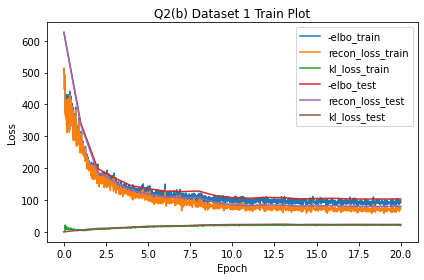

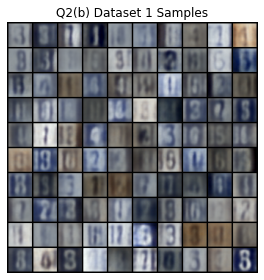

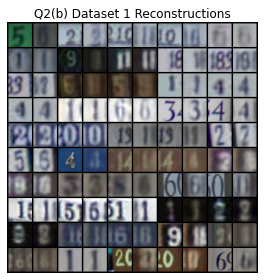

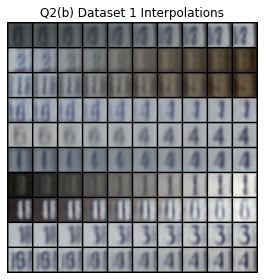

In [209]:
q2_save_results('b', 1, q2_b)

Final -ELBO: 238.6986, Recon Loss: 209.2914, KL Loss: 29.4072


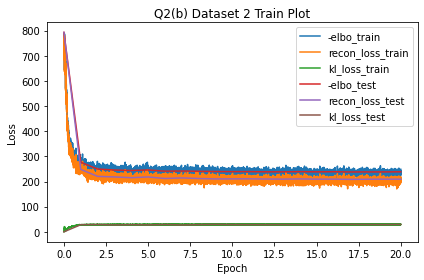

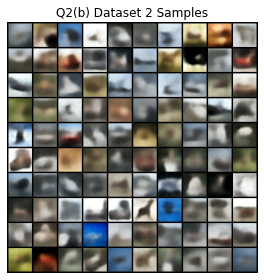

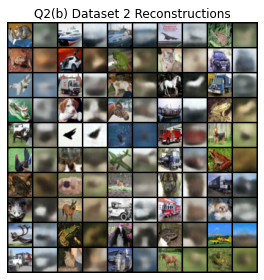

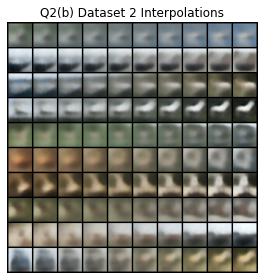

In [89]:
q2_save_results('b', 2, q2_b)

# Question 3: VQ-VAE [40pts]
In this question, you with train a [VQ-VAE](https://arxiv.org/abs/1711.00937) on the colored shapes dataset and SVHN. If you are confused on how the VQ-VAE works, you may find [Lilian Weng's blogpost](https://lilianweng.github.io/lil-log/2018/08/12/from-autoencoder-to-beta-vae.html#vq-vae-and-vq-vae-2) to be useful.

You may experiment with different hyperparameters and architecture designs, but the following designs for the VQ-VAE architecture may be useful.

```
conv2d(in_channels, out_channels, kernel_size, stride, padding)
transpose_conv2d(in_channels, out_channels, kernel_size, stride, padding)
linear(in_dim, out_dim)
batch_norm2d(dim)

residual_block(dim)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 3, 1, 1)
    batch_norm2d(dim)
    relu()
    conv2d(dim, dim, 1, 1, 0)

Encoder
    conv2d(3, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    conv2d(256, 256, 4, 2, 1) 8 x 8
    residual_block(256)
    residual_block(256)

Decoder
    residual_block(256)
    residual_block(256)
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 256, 4, 2, 1) 16 x 16
    batch_norm2d(256)
    relu()
    transpose_conv2d(256, 3, 4, 2, 1) 32 x 32
```

A few other tips:
*   Use a codebook with $K = 128$ latents each with a $D = 256$ dimensional embedding vector
*   You should initialize each element in your $K\times D$ codebook to be uniformly random in $[-1/K, 1/K]$
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer
*   Center and scale your images to $[-1, 1]$
*   Supposing that $z_e(x)$ is the encoder output, and $z_q(x)$ is the quantized output using the codebook, you can implement the straight-through estimator as follows (where below is fed into the decoder): 
  * `(z_q(x) - z_e(x)).detach() + z_e(x)` in Pytorch
  * `tf.stop_gradient(z_q(x) - z_e(x)) + z_e(x)` in Tensorflow.

In addition to training the VQ-VAE, you will also need to train a PixelCNN prior on the categorical latents in order to sample. For your architecture, you may find the following useful:
*   Since the input is a 2D grid of discrete values, you should have an input (learned) embedding layer to map the discrete values to embeddings of length $64$
*   Use a single Type A masked convolutions followed by 10-15 residual blocks (same structure as HW 1), and $2$ $1\times 1$ convolutions of $512$ and $K$ channels respectively.
*   You may find normalization methods (e.g. BatchNorm, LayerNorm) to be useful
*   Use batch size 128 with a learning rate of $10^{-3}$ and an Adam optimizer

**You will provide the following deliverables**


1.   Over the course of training, record the average loss of the training data (per minibatch) and test data (for your entire test set) **for both your VQ-VAE and PixelCNN prior**. Code is provided that automatically plots the training curves. 
2. Report the final test set performances of your final models
3. 100 samples from your trained VQ-VAE and PixelCNN prior
4. 50 real-image / reconstruction pairs (for some $x$, encode and then decode)

## Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def q3(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of PixelCNN prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of PixelCNN prior train losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """

## Results
Once you've finished `q3`, execute the cells below to visualize and save your results.

VQ-VAE Final Test Loss: 0.0286
PixelCNN Prior Final Test Loss: 1.9440


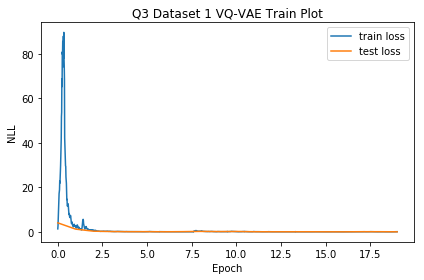

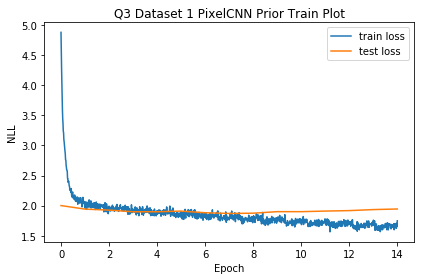

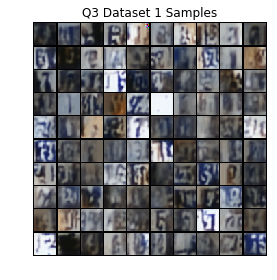

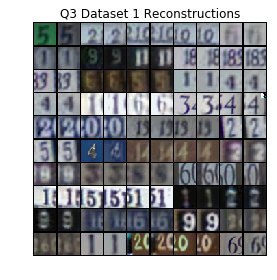

In [ ]:
q3_save_results(1, q3)

In [ ]:
q3_save_results(2, q3)

# Question 4 Bonus [15pts]

## Part (a) Improving VQ-VAE Results [10pts]
Improve upon your results in Q3, one option being trying to implement or train a stronger autoregressive model such as a Gated PixelCNN.

### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def q4_a(train_data, test_data, dset_id):
    """
    train_data: An (n_train, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    test_data: An (n_test, 32, 32, 3) uint8 numpy array of color images with values in [0, 255]
    dset_id: An identifying number of which dataset is given (1 or 2). Most likely
               used to set different hyperparameters for different datasets

    Returns
    - a (# of training iterations,) numpy array of VQ-VAE train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of VQ-VAE train losses evaluated once at initialization and after each epoch
    - a (# of training iterations,) numpy array of PixelCNN prior train losess evaluated every minibatch
    - a (# of epochs + 1,) numpy array of PixelCNN prior train losses evaluated once at initialization and after each epoch
    - a (100, 32, 32, 3) numpy array of 100 samples with values in {0, ... 255}
    - a (100, 32, 32, 3) numpy array of 50 real image / reconstruction pairs
      FROM THE TEST SET with values in [0, 255]
    """

    """ YOUR CODE HERE """

### Results
Once you've finished `q4_a`, execute the cells below to visualize and save your results.

In [ ]:
q4_a_save_results(2, q4_a)

## Part (b) PixelVAE [5pts]
Implement and train a VAE with a PixelCNN decoder, and get it to produce good samples but not ignore latents. It may help to reference the latent variable model slides on techniques to prevent posterior collapse.

### Solution
Fill out the function below and return the neccessary arguments. Feel free to create more cells if need be

In [ ]:
def q4_b(train_data, test_data):
    """
    train_data: An (n_train, 28, 28, 1) uint8 numpy array of MNIST binary images
    test_data: An (n_test, 28, 28, 1) uint8 numpy array of MNIST binary images

    Returns
    - a (# of training iterations, 3) numpy array of full negative ELBO, reconstruction loss E[-log p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated every minibatch
    - a (# of epochs + 1, 3) numpy array of full negative ELBO, reconstruciton loss E[-p(x|z)],
      and KL term E[KL(q(z|x) | p(z))] evaluated once at initialization and after each epoch
    - a (100, 28, 28, 1) numpy array of 100 samples with values in {0, 1}
    - a (100, 28, 28, 1) numpy array of 50 real-image / reconstruction pairs with values in {0, 1}
    """

    """ YOUR CODE HERE """ 

### Results
Once you've finished `q4_b`, execute the cells below to visualize and save your results

In [ ]:
q4_b_save_results(q4_b)

# File Saving Utility


In [ ]:
# one way to save files
from google.colab import files
import os
import os.path as osp
for fname in os.listdir('results'):
    files.download('results/' + fname)